In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import Logit
import patsy
from joblib import load, dump

import model_functions as mf
import eval_measures as ems

from IPython.display import display

MF reloaded 1
EMS reloaded


In [2]:
MODEL_VERSION = "v4"
MODEL_SUFFIX = "%s.first_author" % MODEL_VERSION
GENDERS = ["-", "F", "M"]
TOP_15_ETHNICITIES = ["ENGLISH", "GERMAN", "HISPANIC", "CHINESE",
                      "JAPANESE", "SLAV", "FRENCH", "ITALIAN", "INDIAN",
                      "NORDIC", "ARAB", "DUTCH", "KOREAN", "UNKNOWN", "OTHER"]
TOP_15_COUNTRIES = ["USA", "UNKNOWN", "UK", "JAPAN", "GERMANY", "FRANCE", "ITALY",
                    "CANADA", "CHINA", "AUSTRALIA", "SPAIN", "NETHERLANDS",
                    "SWEDEN", "INDIA", "OTHER"]

sns.set_context("poster")
sns.set_style("ticks")

In [3]:
def filtered_data(df, max_source_ncites=100, version=1):
    # Base version 1
    df_filtered = df[(df.source_country == "USA")
                & (df.source_is_eng)
                & (df.source_is_journal)
                & (df.source_ncites >= 10)
                & (df.source_ncites <=max_source_ncites)]
    if version == 2:
        df_filtered = df_filtered[(df.eth1 == "ENGLISH")
                & (df.eth2 == "UNKNOWN")]
    print df_filtered.shape, df.shape
    return df_filtered


def fit_model(df, base_formula, include_prc=True, MODEL_VERSION="v4", MODEL_SUFFIX="", version=1):
    results_full = []
    nrows, ncols = 1,1
    figsize = 5
    if include_prc:
        fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True,
                               squeeze=False, figsize=(ncols*figsize, nrows*figsize))
        fig1, ax1 = plt.subplots(nrows, ncols, sharex=True, sharey=True,
                                 squeeze=False, figsize=(ncols*figsize, nrows*figsize))
        print "Created figure with %s rows and %s columns" % (nrows, ncols)
        ax = ax.flatten()
        ax1 = ax1.flatten()

    formula = base_formula
    i = 0
    measures, summary = model_fit(df, formula, include_prc=include_prc)

    prc = measures.pop("prc", None)
    roc = measures.pop("roc", None)
    if include_prc and prc is not None and roc is not None:
        ## PRC
        plot_prc(prc, ax=ax[i], color="k")
        ax[i].plot([measures["recall"]], [measures["precision"]], marker="o",
                   color="k", linestyle="none", ms=15)
        ax[i].plot([0,1], [1,0], "--k", linewidth=1)
        ax[i].set_xlabel("Recall")
        ax[i].set_ylabel("Precision")
        ## ROC
        plot_prc(roc, ax=ax1[i], color="k")
        ax1[i].plot([measures["fpr"]], [measures["tpr"]], marker="o",
                   color="k", linestyle="none", ms=15)
        ax1[i].plot([0,1], [0,1], "--k", linewidth=1)
        ax1[i].set_xlabel("False Positive Rate")
        ax1[i].set_ylabel("True Positive Rate")
    print measures
    print display(summary)
    results_full.append(("all", (measures, summary)))

    if include_prc:
        fig.tight_layout()
        fig.savefig("PRC_model.%s.filtered_%s.pdf" % (MODEL_SUFFIX, version), bbox_inches="tight")
        fig1.tight_layout()
        fig1.savefig("ROC_model.%s.filtered_%s.pdf" % (MODEL_SUFFIX, version), bbox_inches="tight")
        
    dump([results_full],
         "results_all_model/%s/results_all_model.%s.filtered_%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX, version))
    return [results_full]

## Load Data

In [4]:
with pd.HDFStore('out/ModelData.20160529.h5') as cstore:
    df = cstore['first_author']
    
with pd.HDFStore('out/ModelData.20160529.h5') as cstore:
    df_la = cstore['last_author']

In [5]:
df.head()

,source_id,source_year,source_n_mesh,source_n_mesh_ex,source_is_eng,source_country,source_is_journal,source_is_review,source_is_case_rep,source_is_let_ed_com,...,eth2,pos,pos_nice,sink_last_ncites,sink_prev_ncites,auth_last_npapers,auth_prev_papers,jj_sim,is_self_cite,eth_weight
0,16526454,2005,11,53,True,JAPAN,True,False,False,False,...,UNKNOWN,1,1,2,1,1,20,14.6053,0,1.0
1,16526454,2005,11,53,True,JAPAN,True,False,False,False,...,UNKNOWN,1,1,1,2,1,20,14.6053,1,1.0
2,14595765,2003,17,71,True,JAPAN,True,False,False,False,...,UNKNOWN,1,1,5,8,1,7,0.0000,0,1.0
3,14595765,2003,17,71,True,JAPAN,True,False,False,False,...,UNKNOWN,1,1,5,17,1,7,5.5691,0,1.0
4,14595765,2003,17,71,True,JAPAN,True,False,False,False,...,UNKNOWN,1,1,9,22,1,7,5.5691,0,1.0


In [6]:
df.columns

Index([u'source_id', u'source_year', u'source_n_mesh', u'source_n_mesh_ex',
       u'source_is_eng', u'source_country', u'source_is_journal',
       u'source_is_review', u'source_is_case_rep', u'source_is_let_ed_com',
       u'source_T_novelty', u'source_V_novelty', u'source_PT_novelty',
       u'source_PV_novelty', u'source_ncites', u'source_n_authors', u'sink_id',
       u'sink_year', u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng',
       u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
       u'sink_is_let_ed_com', u'sink_T_novelty', u'sink_V_novelty',
       u'sink_PT_novelty', u'sink_PV_novelty', u'sink_n_authors', u'year_span',
       u'journal_same', u'mesh_sim', u'title_sim', u'lang_sim',
       u'affiliation_sim', u'pubtype_sim', u'cite_sim', u'author_sim',
       u'gender_sim', u'eth_sim', u'n_common_authors', u'gender', u'eth1',
       u'eth2', u'pos', u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_last_npapers', u'auth_prev_papers', u'jj_

In [7]:
def plot_prc(prc, ax, color="k", label="PRC"):
    precision, recall = prc
    ax.plot(recall, precision, 
            marker="None", linestyle="-",
            color=color, label=label)

def get_all_eval_measures(predict, endog, include_prc=False):
    measures = {}
    pred_table = ems.cm(predict, endog)
    measures["precision"] = ems.precision(pred_table)
    measures["recall"] = ems.recall(pred_table)
    measures["accuracy"] = ems.accuracy(pred_table)
    measures["f_score"] = ems.fscore_measure(pred_table)
    measures["rmse"] = ems.rmse(predict, endog)
    measures["mae"] = ems.mae(predict, endog)
    measures["auc"] = ems.auc(predict, endog)
    tn, fp, fn, tp = map(float, pred_table.flatten()) # WRT to 1 as positive label
    measures["tn"] = tn
    measures["fn"] = fn
    measures["fp"] = fp
    measures["tp"] = tp
    measures["tpr"] = tp * 1. / (tp + fn) 
    measures["fpr"] = fp * 1. / (fp + tn) 
    print "In eval measures function."
    if include_prc:
        ## Include the precision recall values
        prc = ems.prc(predict, endog, float_precision=3)
        measures["prc"] = prc
        roc = ems.roc(predict, endog, float_precision=3)
        measures["roc"] = roc
    return measures


def model_fit(df, formula, testing=False, include_prc=False):
    if testing:
        # If testing the just print X and y columns
        print df.shape, formula, include_prc
        return ({"llf": 0.1}, "TEMP SUMMARY")
    ## Not testing. Fit the models and return the measures
    print df.shape, formula, include_prc
    y,X = patsy.dmatrices(formula, data=df, return_type="dataframe")
    print "Created dataframes"
    print "X.shape = %s, y.shape = %s" % (X.shape, y.shape)
    model = Logit(y,X)
    res = model.fit()
    predict = res.predict()
    measures = get_all_eval_measures(predict, model.endog, include_prc=include_prc)
    measures["llf"] = res.llf
    measures["aic"] = res.aic
    measures["bic"] = res.bic
    measures["prsquared"] = res.prsquared
    measures["df_model"] = res.df_model
    return (measures, res.summary2())


def print_model(results_filtered, fp):
    columns = ["llf", "aic", "bic", "prsquared", "df_model",
               "precision", "recall", "f_score", "auc", "mae",
               "rmse", "tp", "fp", "tn", "fn", "tpr", "fpr"]
    measures = pd.DataFrame(columns=columns)
    for j,(m,s) in results_filtered[0]:
        print >> fp, "%s\t%s\t%s" % ("*"*50, j, "*"*50)
        measures.ix[j,columns] = [m[k] for k in columns]
        print >> fp, s
    print >> fp, "%s\t%s\t%s" % ("*"*50, "All Measures", "*"*50)
    print >> fp, measures.to_string()

## Fit models version 1

**Filters applied**
* pub type = journal article
* affiliation = USA
* language = English
* \# source references = [10,x], where x represents the second kink in the fit vs. empirical plots (perhaps 100 for first authors and ~ 40 or 50 for last authors).

In [9]:
base_formula = ("is_self_cite ~ I(auth_prev_papers == 0) + I(auth_prev_papers == 1) "
           "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
           "+ C(gender, levels=GENDERS)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           "+ np.log10(source_ncites) "
           "+ I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)"
           "+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))"
           "+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"
           "+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
          )

version = 1

### First author

In [10]:
df_filtered = filtered_data(df, max_source_ncites=100, version=version)

(13046025, 54) (41618369, 54)


Created figure with 1 rows and 1 columns
(13046025, 54) is_self_cite ~ I(auth_prev_papers == 0) + I(auth_prev_papers == 1) + np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)+ C(gender, levels=GENDERS)+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)+ np.log10(source_ncites) + I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com+ np.log10(np.nan_

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                    Results: Logit
======================================================================================================================
Model:                               Logit                             Pseudo R-squared:                  0.202       
Dependent Variable:                  is_self_cite                      AIC:                               4085258.4353
Date:                                2016-07-26 11:51                  BIC:                               4085977.6350
No. Observations:                    13046025                          Log-Likelihood:                    -2.0426e+06 
Df Model:                            49                                LL-Null:                           -2.5599e+06 
Df Residuals:                        13045975                          LLR p-value:                       0.0000      
Converged:                           1.0000                            Scale:                             1.0000      
No. Iterations:                      10.0000                                                                          
----------------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                                            -4.0473   0.2895  -13.9810 0.0000 -4.6147 -3.4799
I(auth_prev_papers == 0)[T.True]                                     -1.2318   0.0179  -68.9285 0.0000 -1.2669 -1.1968
I(auth_prev_papers == 1)[T.True]                                     -0.1594   0.0099  -16.1068 0.0000 -0.1788 -0.1400
C(gender, levels=GENDERS)[T.F]                                       -0.0518   0.0057   -9.0221 0.0000 -0.0630 -0.0405
C(gender, levels=GENDERS)[T.M]                                       -0.0297   0.0053   -5.6235 0.0000 -0.0401 -0.0194
I(source_n_authors > 20)[T.True]                                     -0.0369   0.0246   -1.4975 0.1343 -0.0851  0.0114
I(source_n_mesh_ex == 0)[T.True]                                     -0.5111   0.0241  -21.2304 0.0000 -0.5583 -0.4639
I(sink_n_mesh_ex == 0)[T.True]                                        0.0193   0.0285    0.6760 0.4991 -0.0366  0.0751
I(year_span < 0)[T.True]                                             -0.4453   0.0284  -15.6950 0.0000 -0.5009 -0.3897
I(year_span == 0)[T.True]                                             0.4459   0.0099   44.8231 0.0000  0.4264  0.4654
I(sink_prev_ncites == 0)[T.True]                                      0.1662   0.0071   23.3037 0.0000  0.1522  0.1802
I(jj_sim == 0)[T.True]                                               -0.1717   0.0148  -11.5941 0.0000 -0.2008 -0.1427
journal_same[T.True]                                                  0.5091   0.0049  104.3436 0.0000  0.4995  0.5187
sink_is_eng[T.True]                                                   2.0747   0.0844   24.5715 0.0000  1.9092  2.2402
sink_is_journal[T.True]                                               0.5478   0.0217   25.1857 0.0000  0.5051  0.5904
sink_is_review[T.True]                                               -0.7406   0.0051 -145.1799 0.0000 -0.7506 -0.7306
sink_is_case_rep[T.True]                                             -0.8818   0.0119  -73.8284 0.0000 -0.9052 -0.8584
sink_is_let_ed_com[T.True]                                           -0.4206   0.0213  -19.7131 0.0000 -0.4624 -0.3788
np.log10(auth_prev_papers + 1)                                        1.8621   0.0132  141.5131 0.0000  1.8363  1.8879
I(np.log10(auth_prev_papers + 1) ** 2)                               -0.1271   0.0044  -29.1441 0.0000 -0.1356 -0.1185
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[0]  -0.0334

None


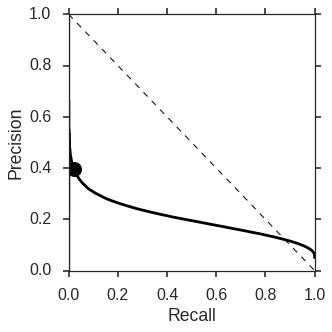

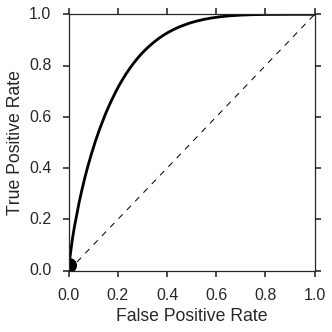

In [11]:
MODEL_VERSION = "v4"
MODEL_SUFFIX = "%s.first_author" % MODEL_VERSION

results_full = fit_model(df_filtered, base_formula, include_prc=True,
                            MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)

In [12]:
results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
    print_model(results_filtered, fp)

### Last author

In [13]:
df_filtered_la = filtered_data(df_la, max_source_ncites=50, version=version)

(8988820, 54) (41618369, 54)


Created figure with 1 rows and 1 columns
(8988820, 54) is_self_cite ~ I(auth_prev_papers == 0) + I(auth_prev_papers == 1) + np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)+ C(gender, levels=GENDERS)+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)+ np.log10(source_ncites) + I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com+ np.log10(np.nan_t

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                     Results: Logit
=========================================================================================================================
Model:                                Logit                              Pseudo R-squared:                   0.112       
Dependent Variable:                   is_self_cite                       AIC:                                5451736.2012
Date:                                 2016-07-26 12:01                   BIC:                                5452436.7758
No. Observations:                     8988820                            Log-Likelihood:                     -2.7258e+06 
Df Model:                             49                                 LL-Null:                            -3.0709e+06 
Df Residuals:                         8988770                            LLR p-value:                        0.0000      
Converged:                            1.0000                             Scale:                              1.0000      
No. Iterations:                       10.0000                                                                            
-------------------------------------------------------------------------------------------------------------------------
                                                                      Coef.   Std.Err.     z     P>|z|   [0.025   0.975] 
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                              0.8550   0.4878    1.7528 0.0796  -0.1011   1.8112
I(auth_prev_papers == 0)[T.True]                                      -1.2593   0.0388  -32.4420 0.0000  -1.3354  -1.1832
I(auth_prev_papers == 1)[T.True]                                      -0.2089   0.0242   -8.6456 0.0000  -0.2562  -0.1615
C(gender, levels=GENDERS)[T.F]                                         0.0004   0.0059    0.0643 0.9488  -0.0112   0.0120
C(gender, levels=GENDERS)[T.M]                                        -0.0114   0.0054   -2.1289 0.0333  -0.0219  -0.0009
I(source_n_authors > 20)[T.True]                                       0.0232   0.0236    0.9827 0.3258  -0.0231   0.0696
I(source_n_mesh_ex == 0)[T.True]                                      -0.7059   0.0201  -35.0348 0.0000  -0.7453  -0.6664
I(sink_n_mesh_ex == 0)[T.True]                                        -0.0930   0.0222   -4.1898 0.0000  -0.1364  -0.0495
I(year_span < 0)[T.True]                                              -0.3821   0.0321  -11.9150 0.0000  -0.4449  -0.3192
I(year_span == 0)[T.True]                                              0.7146   0.0092   77.9346 0.0000   0.6966   0.7326
I(sink_prev_ncites == 0)[T.True]                                       0.2968   0.0064   46.6158 0.0000   0.2843   0.3092
I(jj_sim == 0)[T.True]                                                -0.1677   0.0126  -13.2876 0.0000  -0.1924  -0.1430
journal_same[T.True]                                                   0.6124   0.0040  152.3333 0.0000   0.6045   0.6203
sink_is_eng[T.True]                                                    2.6562   0.1022   26.0004 0.0000   2.4560   2.8565
sink_is_journal[T.True]                                                0.5370   0.0197   27.2198 0.0000   0.4983   0.5757
sink_is_review[T.True]                                                -0.6616   0.0042 -158.7592 0.0000  -0.6697  -0.6534
sink_is_case_rep[T.True]                                              -1.0378   0.0107  -96.6286 0.0000  -1.0589  -1.0168
sink_is_let_ed_com[T.True]                                            -0.3867   0.0193  -20.0859 0.0000  -0.4244  -0.3489
np.log10(auth_prev_papers + 1)                                         2.4576   0.0161  152.6372 0.0000   2.4261   2.4892
I(np.log10(auth_prev_papers + 1) ** 2)                                -0.4035   0.0045  -90.3873 0.00

None


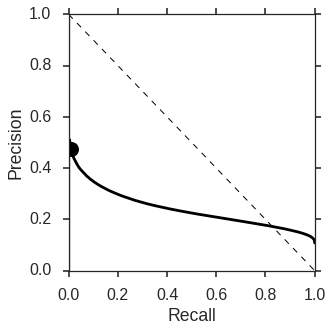

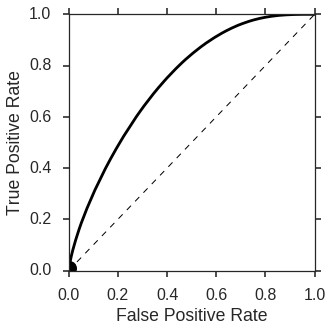

In [14]:
MODEL_VERSION = "v4"
MODEL_SUFFIX = "%s.last_author" % MODEL_VERSION

results_full = fit_model(df_filtered_la, base_formula, include_prc=True,
                            MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)

In [15]:
results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
    print_model(results_filtered, fp)

## Fit models version 2


**Filters applied**


* pub type = journal article
* affiliation = USA
* language = English
* \# source references = [10,x], where x represents the second kink in the fit vs. empirical plots (perhaps 100 for first authors and ~ 40 or 50 for last authors).
* eth1 = ENGLISH, eth2 = UNKNOWN

In [16]:
base_formula = ("is_self_cite ~ I(auth_prev_papers == 0) + I(auth_prev_papers == 1) "
           "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
           "+ C(gender, levels=GENDERS)"
           #"+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           "+ np.log10(source_ncites) "
           "+ I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)"
           "+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))"
           "+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"
           "+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
          )

version = 2

### First author

In [17]:
df_filtered = filtered_data(df, max_source_ncites=100, version=version)

/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(5019975, 54) (41618369, 54)


Created figure with 1 rows and 1 columns
(5019975, 54) is_self_cite ~ I(auth_prev_papers == 0) + I(auth_prev_papers == 1) + np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)+ C(gender, levels=GENDERS)+ np.log10(source_ncites) + I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com+ np.log10(np.nan_to_num(source_V_novelty) + 1)+ np.log10(np.nan_to_num(sink_V_novelt

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Results: Logit
====================================================================================================
Model:                         Logit                       Pseudo R-squared:            0.191       
Dependent Variable:            is_self_cite                AIC:                         1778165.6855
Date:                          2016-07-26 12:06            BIC:                         1778649.1272
No. Observations:              5019975                     Log-Likelihood:              -8.8905e+05 
Df Model:                      35                          LL-Null:                     -1.0984e+06 
Df Residuals:                  5019939                     LLR p-value:                 0.0000      
Converged:                     1.0000                      Scale:                       1.0000      
No. Iterations:                11.0000                                                              
----------------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------
Intercept                                           -3.5424   0.4819  -7.3503 0.0000 -4.4870 -2.5978
I(auth_prev_papers == 0)[T.True]                    -1.2362   0.0297 -41.6214 0.0000 -1.2945 -1.1780
I(auth_prev_papers == 1)[T.True]                    -0.1583   0.0166  -9.5147 0.0000 -0.1909 -0.1257
C(gender, levels=GENDERS)[T.F]                      -0.0333   0.0122  -2.7402 0.0061 -0.0571 -0.0095
C(gender, levels=GENDERS)[T.M]                      -0.0061   0.0117  -0.5164 0.6056 -0.0290  0.0169
I(source_n_authors > 20)[T.True]                    -0.0473   0.0339  -1.3960 0.1627 -0.1137  0.0191
I(source_n_mesh_ex == 0)[T.True]                    -0.6282   0.0365 -17.2302 0.0000 -0.6997 -0.5568
I(sink_n_mesh_ex == 0)[T.True]                      -0.1561   0.0436  -3.5751 0.0004 -0.2416 -0.0705
I(year_span < 0)[T.True]                            -0.3271   0.0414  -7.9000 0.0000 -0.4083 -0.2460
I(year_span == 0)[T.True]                            0.5802   0.0154  37.6863 0.0000  0.5500  0.6103
I(sink_prev_ncites == 0)[T.True]                     0.1564   0.0108  14.4536 0.0000  0.1352  0.1776
I(jj_sim == 0)[T.True]                              -0.1629   0.0220  -7.3919 0.0000 -0.2060 -0.1197
journal_same[T.True]                                 0.5009   0.0075  66.8221 0.0000  0.4862  0.5156
sink_is_eng[T.True]                                  3.6246   0.2680  13.5227 0.0000  3.0992  4.1499
sink_is_journal[T.True]                              0.4962   0.0317  15.6474 0.0000  0.4341  0.5584
sink_is_review[T.True]                              -0.6393   0.0074 -86.4486 0.0000 -0.6538 -0.6248
sink_is_case_rep[T.True]                            -0.8612   0.0172 -50.1023 0.0000 -0.8949 -0.8275
sink_is_let_ed_com[T.True]                          -0.4512   0.0314 -14.3747 0.0000 -0.5127 -0.3897
np.log10(auth_prev_papers + 1)                       1.9110   0.0200  95.7579 0.0000  1.8719  1.9501
I(np.log10(auth_prev_papers + 1) ** 2)              -0.1558   0.0064 -24.2642 0.0000 -0.1684 -0.1432
np.log10(source_ncites)                             -7.3952   0.8157  -9.0664 0.0000 -8.9939 -5.7965
I(np.log10(source_ncites) ** 2)                      5.4000   0.5505   9.8097 0.0000  4.3211  6.4789
I(np.log10(source_ncites) ** 3)                     -1.3862   0.1219 -11.3686 0.0000 -1.6252 -1.1472
np.log10(np.clip(source_n_authors, 0, 20))           0.3029   0.0446   6.7977 0.0000  0.2156  0.3902
I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)  -0.3527   0.0332 -10.6089 0.0000 -0.4178 -0.2875
np.log10(source_n_mesh_ex + 1)                      -0.1505   0.0142 -10.6107 0.0000 -0.1783 -0.1227
np.log10(sink_n_mesh_ex + 1)                        -0.

None


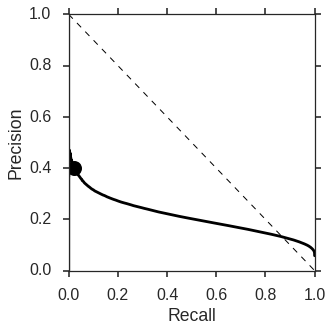

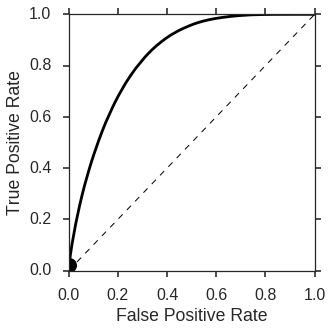

In [18]:
MODEL_VERSION = "v4"
MODEL_SUFFIX = "%s.first_author" % MODEL_VERSION

results_full = fit_model(df_filtered, base_formula, include_prc=True,
                            MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)

In [19]:
results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
    print_model(results_filtered, fp)

### Last author

In [20]:
df_filtered_la = filtered_data(df_la, max_source_ncites=50, version=version)

/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(4849982, 54) (41618369, 54)


Created figure with 1 rows and 1 columns
(4849982, 54) is_self_cite ~ I(auth_prev_papers == 0) + I(auth_prev_papers == 1) + np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)+ C(gender, levels=GENDERS)+ np.log10(source_ncites) + I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com+ np.log10(np.nan_to_num(source_V_novelty) + 1)+ np.log10(np.nan_to_num(sink_V_novelt

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                             Results: Logit
========================================================================================================
Model:                           Logit                        Pseudo R-squared:             0.109       
Dependent Variable:              is_self_cite                 AIC:                          2974281.7873
Date:                            2016-07-26 12:10             BIC:                          2974763.9888
No. Observations:                4849982                      Log-Likelihood:               -1.4871e+06 
Df Model:                        35                           LL-Null:                      -1.6690e+06 
Df Residuals:                    4849946                      LLR p-value:                  0.0000      
Converged:                       1.0000                       Scale:                        1.0000      
No. Iterations:                  11.0000                                                                
--------------------------------------------------------------------------------------------------------
                                                     Coef.   Std.Err.     z     P>|z|   [0.025   0.975] 
--------------------------------------------------------------------------------------------------------
Intercept                                            -0.4911   0.6950   -0.7065 0.4799  -1.8533   0.8712
I(auth_prev_papers == 0)[T.True]                     -1.2363   0.0544  -22.7108 0.0000  -1.3430  -1.1296
I(auth_prev_papers == 1)[T.True]                     -0.1887   0.0349   -5.4125 0.0000  -0.2570  -0.1204
C(gender, levels=GENDERS)[T.F]                        0.0340   0.0108    3.1578 0.0016   0.0129   0.0551
C(gender, levels=GENDERS)[T.M]                        0.0045   0.0102    0.4441 0.6570  -0.0155   0.0246
I(source_n_authors > 20)[T.True]                     -0.0372   0.0320   -1.1620 0.2452  -0.0999   0.0255
I(source_n_mesh_ex == 0)[T.True]                     -0.9082   0.0276  -32.8883 0.0000  -0.9623  -0.8540
I(sink_n_mesh_ex == 0)[T.True]                       -0.1062   0.0304   -3.4929 0.0005  -0.1658  -0.0466
I(year_span < 0)[T.True]                             -0.3941   0.0438   -9.0025 0.0000  -0.4799  -0.3083
I(year_span == 0)[T.True]                             0.7484   0.0126   59.5842 0.0000   0.7238   0.7730
I(sink_prev_ncites == 0)[T.True]                      0.2924   0.0087   33.7215 0.0000   0.2754   0.3094
I(jj_sim == 0)[T.True]                               -0.1879   0.0169  -11.1327 0.0000  -0.2209  -0.1548
journal_same[T.True]                                  0.6156   0.0054  114.4935 0.0000   0.6051   0.6261
sink_is_eng[T.True]                                   3.9592   0.2677   14.7895 0.0000   3.4345   4.4838
sink_is_journal[T.True]                               0.5745   0.0270   21.3152 0.0000   0.5217   0.6273
sink_is_review[T.True]                               -0.6413   0.0056 -113.6266 0.0000  -0.6523  -0.6302
sink_is_case_rep[T.True]                             -1.0461   0.0144  -72.4814 0.0000  -1.0744  -1.0178
sink_is_let_ed_com[T.True]                           -0.3730   0.0262  -14.2362 0.0000  -0.4244  -0.3217
np.log10(auth_prev_papers + 1)                        2.4676   0.0225  109.7519 0.0000   2.4235   2.5117
I(np.log10(auth_prev_papers + 1) ** 2)               -0.4013   0.0061  -65.2533 0.0000  -0.4133  -0.3892
np.log10(source_ncites)                             -17.4836   1.4198  -12.3139 0.0000 -20.2664 -14.7008
I(np.log10(source_ncites) ** 2)                      13.4201   1.0390   12.9169 0.0000  11.3838  15.4564
I(np.log10(source_ncites) ** 3)                      -3.4219   0.2508  -13.6445 0.0000  -3.9134  -2.9303
np.log10(np.clip(source_n_authors, 0, 20))           -0.1828   0.0350   -5.2234 0.0000  -0.2514  -0.1142
I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)   -0.0873   0.0261   -3.3514 0.0008  -0.1384  -0.0363
np.log

None


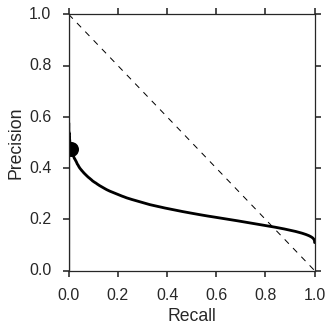

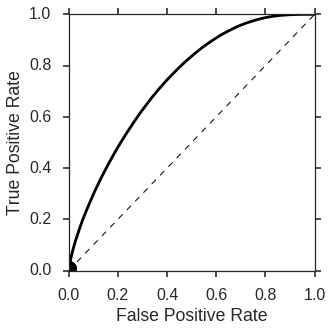

In [21]:
MODEL_VERSION = "v4"
MODEL_SUFFIX = "%s.last_author" % MODEL_VERSION

results_full = fit_model(df_filtered_la, base_formula, include_prc=True,
                            MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)

In [22]:
results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
    print_model(results_filtered, fp)

## Build combined tables

In [67]:
def merge_results(results, keys=("Full", "Filtered 1", "Filtered 2"), columns=("Coef.", "Std.Err.", "P>|z|")):
    df_list = []
    columns = list(columns)
    for r in results:
        df_list.append(r[-1][0][1][1].tables[1][columns])
    df_t = pd.concat(df_list, keys=keys, axis=1)
    df_t = df_t.reindex(results[0][-1][0][1][1].tables[1].index)
    return df_t
    

### First author

In [73]:
MODEL_VERSION = "v4"
MODEL_SUFFIX = "%s.first_author" % MODEL_VERSION

results_full = load("results_all_model/%s/results_all_model.%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX))
results_flt_1 = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX, 1))
results_flt_2 = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX, 2))

In [74]:
df_t = merge_results([results_full, results_flt_1, results_flt_2])
with pd.option_context("display.max_columns", 20, "display.max_rows", 200, "precision", 3):
    display(df_t)

Full           \
                                                        Coef. Std.Err.   
Intercept                                          -1.957e+00    0.031   
I(sink_prev_ncites == 0)[T.True]                    1.265e-01    0.004   
np.log10(sink_prev_ncites + 1)                     -4.433e-01    0.006   
I(np.log10(sink_prev_ncites + 1) ** 2)             -1.698e-01    0.002   
I(auth_prev_papers == 0)[T.True]                   -1.421e+00    0.009   
I(auth_prev_papers == 1)[T.True]                   -2.357e-01    0.005   
np.log10(auth_prev_papers + 1)                      1.610e+00    0.007   
I(np.log10(auth_prev_papers + 1) ** 2)             -9.062e-02    0.002   
source_is_journal[T.True]                           2.661e-01    0.011   
source_is_review[T.True]                           -7.869e-02    0.003   
source_is_case_rep[T.True]                         -9.404e-01    0.007   
source_is_let_ed_com[T.True]                       -4.295e-01    0.011   
sink_is_journal[T.True]                             3.283e-01    0.011   
sink_is_review[T.True]                             -7.826e-01    0.003   
sink_is_case_rep[T.True]                           -6.369e-01    0.006   
sink_is_let_ed_com[T.True]                         -2.838e-01    0.011   
I(year_span < 0)[T.True]                           -5.564e-01    0.016   
I(year_span == 0)[T.True]                           5.382e-01    0.006   
mf.score_log_1(year_span)                           5.387e-01    0.015   
I(mf.score_log_1(year_span) ** 2)                  -1.281e+00    0.010   
journal_same[T.True]                                4.567e-01    0.003   
I(jj_sim == 0)[T.True]                             -2.805e-01    0.008   
np.log10(jj_sim + 1)                                6.298e-02    0.010   
I(np.log10(jj_sim + 1) ** 2)                        5.949e-03    0.003   
I(source_ncites == 1)[T.True]                      -2.997e-01    0.022   
np.log10(source_ncites)                            -1.647e+00    0.034   
I(np.log10(source_ncites) ** 2)                     8.198e-01    0.023   
I(np.log10(source_ncites) ** 3)                    -2.294e-01    0.005   
C(source_country, levels=TOP_15_COUNTRIES)[T.UN... -4.468e-02    0.006   
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]   -5.242e-03    0.003   
C(source_country, levels=TOP_15_COUNTRIES)[T.JA...  2.669e-01    0.006   
C(source_country, levels=TOP_15_COUNTRIES)[T.GE...  2.382e-02    0.004   
C(source_country, levels=TOP_15_COUNTRIES)[T.FR... -4.425e-02    0.005   
C(source_country, levels=TOP_15_COUNTRIES)[T.IT... -1.010e-01    0.007   
C(source_country, levels=TOP_15_COUNTRIES)[T.CA... -3.874e-03    0.004   
C(source_country, levels=TOP_15_COUNTRIES)[T.CH... -4.120e-01    0.010   
C(source_country, levels=TOP_15_COUNTRIES)[T.AU...  8.788e-02    0.005   
C(source_country, levels=TOP_15_COUNTRIES)[T.SP... -1.223e-01    0.006   
C(source_country, levels=TOP_15_COUNTRIES)[T.NE...  6.808e-02    0.007   
C(source_country, levels=TOP_15_COUNTRIES)[T.SW...  1.074e-01    0.007   
C(source_country, levels=TOP_15_COUNTRIES)[T.IN... -4.363e-02    0.010   
C(source_country, levels=TOP_15_COUNTRIES)[T.OT... -6.440e-02    0.003   
np.log10(np.nan_to_num(source_V_novelty) + 1)      -1.058e-01    0.001   
np.log10(np.nan_to_num(sink_V_novelty) + 1)         9.484e-02    0.008   
I(np.log10(np.nan_to_num(sink_V_novelty) + 1) *... -2.774e-02    0.001   
source_is_eng[T.True]                               6.494e-01    0.007   
sink_is_eng[T.True]                                -1.846e-01    0.010   
I(source_n_authors > 20)[T.True]                    1.722e-04    0.015   
np.log10(np.clip(source_n_authors, 0, 20))          8.239e-02    0.018   
I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2) -2.563e-01    0.013   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO... -1.426e-02    0.004   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  5.313e-02    0.004   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  4.562e-02

### Last author

In [75]:
MODEL_VERSION = "v4"
MODEL_SUFFIX = "%s.last_author" % MODEL_VERSION

results_full_la = load("results_all_model/%s/results_all_model.%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX))
results_flt_1_la = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX, 1))
results_flt_2_la = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX, 2))

In [76]:
df_t_la = merge_results([results_full_la, results_flt_1_la, results_flt_2_la])
with pd.option_context("display.max_columns", 20, "display.max_rows", 200, "precision", 3):
    display(df_t_la)

Full             \
                                                    Coef.   Std.Err.   
Intercept                                          -2.790  2.674e-02   
I(year_span < 0)[T.True]                           -0.383  1.459e-02   
I(year_span == 0)[T.True]                           0.735  4.656e-03   
mf.score_log_1(year_span)                           1.232  1.131e-02   
I(mf.score_log_1(year_span) ** 2)                  -1.402  6.820e-03   
I(auth_prev_papers == 0)[T.True]                   -1.232  1.639e-02   
I(auth_prev_papers == 1)[T.True]                   -0.187  1.058e-02   
np.log10(auth_prev_papers + 1)                      2.172  7.733e-03   
I(np.log10(auth_prev_papers + 1) ** 2)             -0.340  2.154e-03   
source_is_journal[T.True]                           0.229  1.021e-02   
source_is_review[T.True]                           -0.249  2.125e-03   
source_is_case_rep[T.True]                         -0.948  5.222e-03   
source_is_let_ed_com[T.True]                       -0.343  9.952e-03   
sink_is_journal[T.True]                             0.324  9.445e-03   
sink_is_review[T.True]                             -0.641  2.142e-03   
sink_is_case_rep[T.True]                           -0.731  4.949e-03   
sink_is_let_ed_com[T.True]                         -0.292  9.374e-03   
journal_same[T.True]                                0.534  2.218e-03   
I(jj_sim == 0)[T.True]                             -0.296  6.332e-03   
np.log10(jj_sim + 1)                                0.126  8.068e-03   
I(np.log10(jj_sim + 1) ** 2)                       -0.050  2.456e-03   
I(sink_prev_ncites == 0)[T.True]                    0.240  3.101e-03   
np.log10(sink_prev_ncites + 1)                     -0.079  4.424e-03   
I(np.log10(sink_prev_ncites + 1) ** 2)             -0.169  1.530e-03   
I(source_ncites == 1)[T.True]                      -0.405  2.079e-02   
np.log10(source_ncites)                            -2.221  3.101e-02   
I(np.log10(source_ncites) ** 2)                     1.463  2.148e-02   
I(np.log10(source_ncites) ** 3)                    -0.387  4.793e-03   
C(source_country, levels=TOP_15_COUNTRIES)[T.UN... -0.158  5.211e-03   
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]   -0.090  2.373e-03   
C(source_country, levels=TOP_15_COUNTRIES)[T.JA... -0.092  6.048e-03   
C(source_country, levels=TOP_15_COUNTRIES)[T.GE... -0.169  3.061e-03   
C(source_country, levels=TOP_15_COUNTRIES)[T.FR... -0.116  3.820e-03   
C(source_country, levels=TOP_15_COUNTRIES)[T.IT... -0.298  4.877e-03   
C(source_country, levels=TOP_15_COUNTRIES)[T.CA... -0.069  3.035e-03   
C(source_country, levels=TOP_15_COUNTRIES)[T.CH... -0.432  7.300e-03   
C(source_country, levels=TOP_15_COUNTRIES)[T.AU... -0.099  4.043e-03   
C(source_country, levels=TOP_15_COUNTRIES)[T.SP... -0.184  4.889e-03   
C(source_country, levels=TOP_15_COUNTRIES)[T.NE... -0.179  5.204e-03   
C(source_country, levels=TOP_15_COUNTRIES)[T.SW... -0.083  4.978e-03   
C(source_country, levels=TOP_15_COUNTRIES)[T.IN... -0.206  8.064e-03   
C(source_country, levels=TOP_15_COUNTRIES)[T.OT... -0.213  2.054e-03   
np.log10(np.nan_to_num(source_V_novelty) + 1)      -0.139  9.809e-04   
np.log10(np.nan_to_num(sink_V_novelty) + 1)         0.048  5.268e-03   
I(np.log10(np.nan_to_num(sink_V_novelty) + 1) *... -0.022  9.206e-04   
I(source_n_authors > 20)[T.True]                   -0.050  1.263e-02   
np.log10(np.clip(source_n_authors, 0, 20))         -0.444  1.368e-02   
I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)  0.066  1.004e-02   
source_is_eng[T.True]                               0.701  6.660e-03   
sink_is_eng[T.True]                                -0.031  8.947e-03   
I(source_n_mesh_ex == 0)[T.True]                   -0.892  9.581e-03   
I(sink_n_mesh_ex == 0)[T.True]                      0.005  1.108e-02   
np.log10(source_n_mesh_ex + 1)                     -0.251  4.138e-03   
np.log10(sink_n_mesh_ex + 1)                       -0.092  4.139e-03   
mf.MC(eth1, eth2, wei

### Both combined

In [77]:
df_t.shape, df_t_la.shape

((70, 9), (70, 9))

In [79]:
set(df_t.index.values) == set(df_t_la.index.values)

True

In [80]:
df_t_both = merge_results([results_full, results_flt_1, results_flt_2,
                           results_full_la, results_flt_1_la, results_flt_2_la],
                         keys=[(k1, k2) for k1 in ("First", "Last") for k2 in ("Full", "Filtered 1", "Filtered 2")])
with pd.option_context("display.max_columns", 20, "display.max_rows", 200, "precision", 3):
    display(df_t_both)

First           \
                                                         Full            
                                                        Coef. Std.Err.   
Intercept                                          -1.957e+00    0.031   
I(sink_prev_ncites == 0)[T.True]                    1.265e-01    0.004   
np.log10(sink_prev_ncites + 1)                     -4.433e-01    0.006   
I(np.log10(sink_prev_ncites + 1) ** 2)             -1.698e-01    0.002   
I(auth_prev_papers == 0)[T.True]                   -1.421e+00    0.009   
I(auth_prev_papers == 1)[T.True]                   -2.357e-01    0.005   
np.log10(auth_prev_papers + 1)                      1.610e+00    0.007   
I(np.log10(auth_prev_papers + 1) ** 2)             -9.062e-02    0.002   
source_is_journal[T.True]                           2.661e-01    0.011   
source_is_review[T.True]                           -7.869e-02    0.003   
source_is_case_rep[T.True]                         -9.404e-01    0.007   
source_is_let_ed_com[T.True]                       -4.295e-01    0.011   
sink_is_journal[T.True]                             3.283e-01    0.011   
sink_is_review[T.True]                             -7.826e-01    0.003   
sink_is_case_rep[T.True]                           -6.369e-01    0.006   
sink_is_let_ed_com[T.True]                         -2.838e-01    0.011   
I(year_span < 0)[T.True]                           -5.564e-01    0.016   
I(year_span == 0)[T.True]                           5.382e-01    0.006   
mf.score_log_1(year_span)                           5.387e-01    0.015   
I(mf.score_log_1(year_span) ** 2)                  -1.281e+00    0.010   
journal_same[T.True]                                4.567e-01    0.003   
I(jj_sim == 0)[T.True]                             -2.805e-01    0.008   
np.log10(jj_sim + 1)                                6.298e-02    0.010   
I(np.log10(jj_sim + 1) ** 2)                        5.949e-03    0.003   
I(source_ncites == 1)[T.True]                      -2.997e-01    0.022   
np.log10(source_ncites)                            -1.647e+00    0.034   
I(np.log10(source_ncites) ** 2)                     8.198e-01    0.023   
I(np.log10(source_ncites) ** 3)                    -2.294e-01    0.005   
C(source_country, levels=TOP_15_COUNTRIES)[T.UN... -4.468e-02    0.006   
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]   -5.242e-03    0.003   
C(source_country, levels=TOP_15_COUNTRIES)[T.JA...  2.669e-01    0.006   
C(source_country, levels=TOP_15_COUNTRIES)[T.GE...  2.382e-02    0.004   
C(source_country, levels=TOP_15_COUNTRIES)[T.FR... -4.425e-02    0.005   
C(source_country, levels=TOP_15_COUNTRIES)[T.IT... -1.010e-01    0.007   
C(source_country, levels=TOP_15_COUNTRIES)[T.CA... -3.874e-03    0.004   
C(source_country, levels=TOP_15_COUNTRIES)[T.CH... -4.120e-01    0.010   
C(source_country, levels=TOP_15_COUNTRIES)[T.AU...  8.788e-02    0.005   
C(source_country, levels=TOP_15_COUNTRIES)[T.SP... -1.223e-01    0.006   
C(source_country, levels=TOP_15_COUNTRIES)[T.NE...  6.808e-02    0.007   
C(source_country, levels=TOP_15_COUNTRIES)[T.SW...  1.074e-01    0.007   
C(source_country, levels=TOP_15_COUNTRIES)[T.IN... -4.363e-02    0.010   
C(source_country, levels=TOP_15_COUNTRIES)[T.OT... -6.440e-02    0.003   
np.log10(np.nan_to_num(source_V_novelty) + 1)      -1.058e-01    0.001   
np.log10(np.nan_to_num(sink_V_novelty) + 1)         9.484e-02    0.008   
I(np.log10(np.nan_to_num(sink_V_novelty) + 1) *... -2.774e-02    0.001   
source_is_eng[T.True]                               6.494e-01    0.007   
sink_is_eng[T.True]                                -1.846e-01    0.010   
I(source_n_authors > 20)[T.True]                    1.722e-04    0.015   
np.log10(np.clip(source_n_authors, 0, 20))          8.239e-02    0.018   
I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2) -2.563e-01    0.013   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO... -1.426e-02    0.004   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  5.313e-0